# EOEPCA+ Use Case: NO2 Tropospheric Content Cloud Filtering - Access and Process


# Table of Contents

1. Introduction
1. Get external data: Cloud Fraction
2. Apply STAC Best Practices
3. Save metadata to the EOEPCA Workspace
4. Register metadata to the EOEPCA STAC API
5. Access and process the data

# Introduction

## What happens in this notebook
Access and process the data sets, S5P Cloud Fraction and S5P NO2 Tropospheric Content, previously registered from external sources into EOEPCA STAC API, to create a cloud filtered monthly composite of NO2 Tropospheric Content. The processing is carried out using the EOEPCA Processing Builidung Block.

![end2end_workflow](img/end2end_workflow_proc.png)

In [1]:
from pystac_client import Client
from odc.stac import stac_load
from datetime import datetime
import numpy as np
import pandas as pd
import openeo

## Cloud Fraction

https://radiantearth.github.io/stac-browser/#/external/eoapi.develop.eoepca.org/stac/collections/s5p-bp-cf-v3?.language=de

In [2]:
url = "https://eoapi.develop.eoepca.org/stac"
catalog = Client.open(url)
#https://eoapi.develop.eoepca.org/stac/collections/s5p-bp-cf-v3
collection_id = "s5p-bp-cf-v3"
bbox = [-10.0, 35.0, 30.0, 70.0]  # Europe
date_time = "2023-08-01T00:00:00Z/2023-12-31T23:59:59Z"

search = catalog.search(
    collections=[collection_id],
    bbox=bbox,
    datetime=date_time,
    limit=400  
)

items = list(search.items())

ds = stac_load(
    items,
    #bands=["CF"], 
    crs="EPSG:4326",
    resolution=0.1,
    bbox=bbox,
    chunks={"time": 1} 
)

monthly_mean_cf = ds['cf'].groupby('time.month').median(dim='time')

monthly_mean_cf

<xarray.DataArray 'cf' (month: 5, latitude: 350, longitude: 400)> Size: 3MB
dask.array<stack, shape=(5, 350, 400), dtype=float32, chunksize=(1, 350, 400), chunktype=numpy.ndarray>
Coordinates:
  * latitude     (latitude) float64 3kB 69.95 69.85 69.75 ... 35.25 35.15 35.05
  * longitude    (longitude) float64 3kB -9.95 -9.85 -9.75 ... 29.75 29.85 29.95
    spatial_ref  int32 4B 4326
  * month        (month) int64 40B 8 9 10 11 12

In [ ]:
%%time
monthly_mean_cf.plot(col="month",
    col_wrap=3,
    cmap="viridis",
    vmin=0,
    vmax=1,
    figsize=(12, 6),
    cbar_kwargs={"label": "Cloud Fraction"})

## Load and process via openEO

### openEO EOEPCA (CDSE)

Connect to openEO backend

In [49]:
openeo_url = 'https://openeo.develop.eoepca.org/openeo/1.2/'
#openeo_url = 'https://openeo.dataspace.copernicus.eu/'
connection = openeo.connect(openeo_url).authenticate_oidc()

Authenticated using refresh token.


In [51]:
#url = "https://eoapi.develop.eoepca.org/stac/collections/s5p-bp-cf-v3" # use collection_id
eoepca_stac_col_url = (f"{eoepca_stac_url}{collection_id}")

# Larger Nürnberg area for the month of september
cube = connection.load_stac(
    url=eoepca_stac_col_url,
    spatial_extent = {
        "west": 10.940,
        "south": 49.340,
        "east": 11.300,
        "north": 49.550,
    },
    temporal_extent=["2023-09-01", "2023-10-01"],
    bands=["cf"]
    
)

cube_mnth = cube.reduce_dimension(dimension="t", reducer="mean") # "t" vs "time"? --> Strange error.
res = cube_mnth.download("s5p_cf_mean.tiff", format="GTiff")

OpenEoApiError: [500] Internal: load_stac: Error when constructing datacube from https://eoapi.develop.eoepca.org/stac/collections/s5p-cf-bp: An error occurred while calling o568.datacube_seq.
: java.io.IOException: Exception while reading RasterSource https://download.geoservice.dlr.de/S5P_TROPOMI/files/L3/2023/09/30/S5P_DLR_OFFL_01_L3_CF_20230930/S5P_DLR_OFFL_01_L3_CF_20230930_cf.tif in collection https://eoapi.develop.eoepca.org/stac/collections/s5p-cf-bp. Detailed message: javax.net.ssl.SSLHandshakeException: PKIX path building failed: sun.security.provider.certpath.SunCertPathBuilderException: unable to find valid certification path to requested target. File does not exist: https:/download.geoservice.dlr.de/S5P_TROPOMI/files/L3/2023/09/30/S5P_DLR_OFFL_01_L3_CF_20230930/S5P_DLR_OFFL_01_L3_CF_20230930_cf.tif.
	at org.openeo.geotrellis.layers.FileLayerProvider.determineCelltype(FileLayerProvider.scala:839)
	at org.openeo.geotrellis.layers.FileLayerProvider.readKeysToRasterSources(FileLayerProvider.scala:872)
	at org.openeo.geotrellis.layers.FileLayerProvider.readMultibandTileLayer(FileLayerProvider.scala:1119)
	at org.openeo.geotrellis.file.PyramidFactory.datacube(PyramidFactory.scala:175)
	at org.openeo.geotrellis.file.PyramidFactory.datacube_seq(PyramidFactory.scala:132)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:829)
Caused by: net.jodah.failsafe.FailsafeException: javax.net.ssl.SSLHandshakeException: PKIX path building failed: sun.security.provider.certpath.SunCertPathBuilderException: unable to find valid certification path to requested target
	at net.jodah.failsafe.FailsafeExecutor.call(FailsafeExecutor.java:385)
	at net.jodah.failsafe.FailsafeExecutor.get(FailsafeExecutor.java:68)
	at org.openeo.geotrellis.package$.withRetryAfterRetries(package.scala:233)
	at org.openeo.geotrellis.CustomizableHttpRangeReader.totalLength$lzycompute(CustomizableHttpRangeReader.scala:18)
	at org.openeo.geotrellis.CustomizableHttpRangeReader.totalLength(CustomizableHttpRangeReader.scala:17)
	at geotrellis.util.StreamingByteReader.ensureChunk(StreamingByteReader.scala:109)
	at geotrellis.util.StreamingByteReader.get(StreamingByteReader.scala:130)
	at geotrellis.raster.io.geotiff.reader.GeoTiffInfo$.read(GeoTiffInfo.scala:127)
	at geotrellis.raster.io.geotiff.reader.GeoTiffReader$.readMultiband(GeoTiffReader.scala:211)
	at geotrellis.raster.geotiff.GeoTiffResampleRasterSource.$anonfun$tiff$1(GeoTiffResampleRasterSource.scala:45)
	at scala.Option.getOrElse(Option.scala:201)
	at geotrellis.raster.geotiff.GeoTiffResampleRasterSource.tiff$lzycompute(GeoTiffResampleRasterSource.scala:42)
	at geotrellis.raster.geotiff.GeoTiffResampleRasterSource.tiff(GeoTiffResampleRasterSource.scala:39)
	at geotrellis.raster.geotiff.GeoTiffResampleRasterSource.$anonfun$cellType$1(GeoTiffResampleRasterSource.scala:49)
	at scala.Option.getOrElse(Option.scala:201)
	at geotrellis.raster.geotiff.GeoTiffResampleRasterSource.cellType(GeoTiffResampleRasterSource.scala:49)
	at org.openeo.geotrellis.layers.BandCompositeRasterSource.$anonfun$cellType$1(BandCompositeRasterSource.scala:100)
	at cats.data.NonEmptyList.map(NonEmptyList.scala:109)
	at org.openeo.geotrellis.layers.BandCompositeRasterSource.cellType(BandCompositeRasterSource.scala:100)
	at org.openeo.geotrellis.layers.FileLayerProvider.determineCelltype(FileLayerProvider.scala:811)
	... 16 more
Caused by: javax.net.ssl.SSLHandshakeException: PKIX path building failed: sun.security.provider.certpath.SunCertPathBuilderException: unable to find valid certification path to requested target
	at java.base/sun.security.ssl.Alert.createSSLException(Alert.java:131)
	at java.base/sun.security.ssl.TransportContext.fatal(TransportContext.java:353)
	at java.base/sun.security.ssl.TransportContext.fatal(TransportContext.java:296)
	at java.base/sun.security.ssl.TransportContext.fatal(TransportContext.java:291)
	at java.base/sun.security.ssl.CertificateMessage$T12CertificateConsumer.checkServerCerts(CertificateMessage.java:654)
	at java.base/sun.security.ssl.CertificateMessage$T12CertificateConsumer.onCertificate(CertificateMessage.java:473)
	at java.base/sun.security.ssl.CertificateMessage$T12CertificateConsumer.consume(CertificateMessage.java:369)
	at java.base/sun.security.ssl.SSLHandshake.consume(SSLHandshake.java:392)
	at java.base/sun.security.ssl.HandshakeContext.dispatch(HandshakeContext.java:443)
	at java.base/sun.security.ssl.HandshakeContext.dispatch(HandshakeContext.java:421)
	at java.base/sun.security.ssl.TransportContext.dispatch(TransportContext.java:183)
	at java.base/sun.security.ssl.SSLTransport.decode(SSLTransport.java:172)
	at java.base/sun.security.ssl.SSLSocketImpl.decode(SSLSocketImpl.java:1506)
	at java.base/sun.security.ssl.SSLSocketImpl.readHandshakeRecord(SSLSocketImpl.java:1416)
	at java.base/sun.security.ssl.SSLSocketImpl.startHandshake(SSLSocketImpl.java:456)
	at java.base/sun.security.ssl.SSLSocketImpl.startHandshake(SSLSocketImpl.java:427)
	at java.base/sun.net.www.protocol.https.HttpsClient.afterConnect(HttpsClient.java:572)
	at java.base/sun.net.www.protocol.https.AbstractDelegateHttpsURLConnection.setNewClient(AbstractDelegateHttpsURLConnection.java:106)
	at java.base/sun.net.www.protocol.https.AbstractDelegateHttpsURLConnection.setNewClient(AbstractDelegateHttpsURLConnection.java:80)
	at java.base/sun.net.www.protocol.http.HttpURLConnection.writeRequests(HttpURLConnection.java:724)
	at java.base/sun.net.www.protocol.http.HttpURLConnection.getInputStream0(HttpURLConnection.java:1613)
	at java.base/sun.net.www.protocol.http.HttpURLConnection.getInputStream(HttpURLConnection.java:1520)
	at java.base/java.net.HttpURLConnection.getResponseCode(HttpURLConnection.java:527)
	at java.base/sun.net.www.protocol.https.HttpsURLConnectionImpl.getResponseCode(HttpsURLConnectionImpl.java:334)
	at scalaj.http.HttpRequest.doConnection(Http.scala:367)
	at scalaj.http.HttpRequest.exec(Http.scala:343)
	at scalaj.http.HttpRequest.asString(Http.scala:492)
	at org.openeo.geotrellis.CustomizableHttpRangeReader.$anonfun$totalLength$1(CustomizableHttpRangeReader.scala:20)
	at org.openeo.geotrellis.package$.$anonfun$withRetryAfterRetries$10(package.scala:234)
	at net.jodah.failsafe.Functions.lambda$get$0(Functions.java:46)
	at net.jodah.failsafe.RetryPolicyExecutor.lambda$supply$0(RetryPolicyExecutor.java:65)
	at net.jodah.failsafe.RetryPolicyExecutor.lambda$supply$0(RetryPolicyExecutor.java:65)
	at net.jodah.failsafe.Execution.executeSync(Execution.java:128)
	at net.jodah.failsafe.FailsafeExecutor.call(FailsafeExecutor.java:378)
	... 35 more
Caused by: sun.security.validator.ValidatorException: PKIX path building failed: sun.security.provider.certpath.SunCertPathBuilderException: unable to find valid certification path to requested target
	at java.base/sun.security.validator.PKIXValidator.doBuild(PKIXValidator.java:439)
	at java.base/sun.security.validator.PKIXValidator.engineValidate(PKIXValidator.java:306)
	at java.base/sun.security.validator.Validator.validate(Validator.java:264)
	at java.base/sun.security.ssl.X509TrustManagerImpl.validate(X509TrustManagerImpl.java:313)
	at java.base/sun.security.ssl.X509TrustManagerImpl.checkTrusted(X509TrustManagerImpl.java:222)
	at java.base/sun.security.ssl.X509TrustManagerImpl.checkServerTrusted(X509TrustManagerImpl.java:129)
	at java.base/sun.security.ssl.CertificateMessage$T12CertificateConsumer.checkServerCerts(CertificateMessage.java:638)
	... 64 more
Caused by: sun.security.provider.certpath.SunCertPathBuilderException: unable to find valid certification path to requested target
	at java.base/sun.security.provider.certpath.SunCertPathBuilder.build(SunCertPathBuilder.java:141)
	at java.base/sun.security.provider.certpath.SunCertPathBuilder.engineBuild(SunCertPathBuilder.java:126)
	at java.base/java.security.cert.CertPathBuilder.build(CertPathBuilder.java:297)
	at java.base/sun.security.validator.PKIXValidator.doBuild(PKIXValidator.java:434)
	... 70 more
 (ref: r-2601191031514da5a8665fd2d863f62f)

### openEO EODC

In [52]:
connection = openeo.connect('https://openeo.eodc.eu/openeo/1.2.0').authenticate_oidc()

Visit https://aai.egi.eu/device?user_code=PGTT-VDWN 📋 to authenticate.

✅ Authorized successfully

Authenticated using device code flow.


In [54]:
#original = "https://geoservice.dlr.de/eoc/ogc/stac/v1/collections/S5P_TROPOMI_L3_P1D_CF"
#url = "https://eoapi.develop.eoepca.org/stac/collections/s5p-bp-cf-v3" # use collection_id
eoepca_stac_col_url

cube = connection.load_stac(
    url=eoepca_stac_col_url,
    spatial_extent = {
        "west": 10.940,
        "south": 49.340,
        "east": 11.300,
        "north": 49.550,
    },
    temporal_extent=["2023-07-01", "2023-10-01"],
    bands=["cf"]  
)

#cube.execute()
cube

In [55]:
cube_mnth = cube.reduce_dimension(dimension="t", reducer="mean")
save = cube_mnth.save_result(format = "GTIFF")
job = save.create_job()
job.start_and_wait()

0:00:00 Job '39b3a530-ece8-432e-a5f1-1a09c1724447': send 'start'
0:00:05 Job '39b3a530-ece8-432e-a5f1-1a09c1724447': queued (progress N/A)
0:00:11 Job '39b3a530-ece8-432e-a5f1-1a09c1724447': queued (progress N/A)
0:00:18 Job '39b3a530-ece8-432e-a5f1-1a09c1724447': queued (progress N/A)
0:00:27 Job '39b3a530-ece8-432e-a5f1-1a09c1724447': running (progress N/A)
0:00:38 Job '39b3a530-ece8-432e-a5f1-1a09c1724447': running (progress N/A)
0:00:51 Job '39b3a530-ece8-432e-a5f1-1a09c1724447': running (progress N/A)
0:01:07 Job '39b3a530-ece8-432e-a5f1-1a09c1724447': running (progress N/A)
0:01:27 Job '39b3a530-ece8-432e-a5f1-1a09c1724447': error (progress N/A)
Your batch job '39b3a530-ece8-432e-a5f1-1a09c1724447' failed. Error logs:
[{'id': '8', 'level': 'error', 'message': "KeyError: 'loadstac1-82d8e597-c17b-487a-86bf-34732ebc8fe7'", 'links': []}, {'id': '69', 'level': 'error', 'message': '    raise APIError.from_response(resp)', 'links': []}, {'id': '70', 'level': 'error', 'message': 'pystac_

JobFailedException: Batch job '39b3a530-ece8-432e-a5f1-1a09c1724447' didn't finish successfully. Status: error (after 0:01:28).

In [ ]:
res = cube_mnth.download("s5p_cf_mean.tiff", format="GTiff")

### openEO client side

In [57]:
local_conn = LocalConnection("./")


Did not load machine learning processes due to missing dependencies: Install them like this: `pip install openeo-processes-dask[implementations, ml]`


In [86]:
cube = local_conn.load_stac(
    url=eoepca_stac_col_url,
    spatial_extent = {
        "west": -10.0,
        "south": 30.0,
        "east": 35.0,
        "north": 70.0,
    },
    temporal_extent=["2023-08-01", "2023-12-31"],
    bands=["cf"]  
)

#cube.execute()
cube

In [75]:
#cube_mnth = cube.reduce_dimension(dimension="time", reducer="mean")

In [87]:
cube_mnth = cube.aggregate_temporal_period(dimension="time", period="month", reducer="mean")

In [88]:
res = cube_mnth.execute()

/dss/dsshome1/06/di38laz/micromamba/envs/eoepca_end2end3/lib/python3.11/site-packages/xarray/groupers.py:487: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  self.index_grouper = pd.Grouper(


In [89]:
res

<xarray.DataArray (bands: 1, time: 6, latitude: 350, longitude: 400)> Size: 3MB
dask.array<transpose, shape=(1, 6, 350, 400), dtype=float32, chunksize=(1, 1, 350, 400), chunktype=numpy.ndarray>
Coordinates:
  * latitude     (latitude) float64 3kB 69.95 69.85 69.75 ... 35.25 35.15 35.05
  * longitude    (longitude) float64 3kB -9.95 -9.85 -9.75 ... 29.75 29.85 29.95
    spatial_ref  int32 4B 4326
  * bands        (bands) object 8B 'cf'
  * time         (time) datetime64[ns] 48B 2023-07-31 2023-08-31 ... 2023-12-31

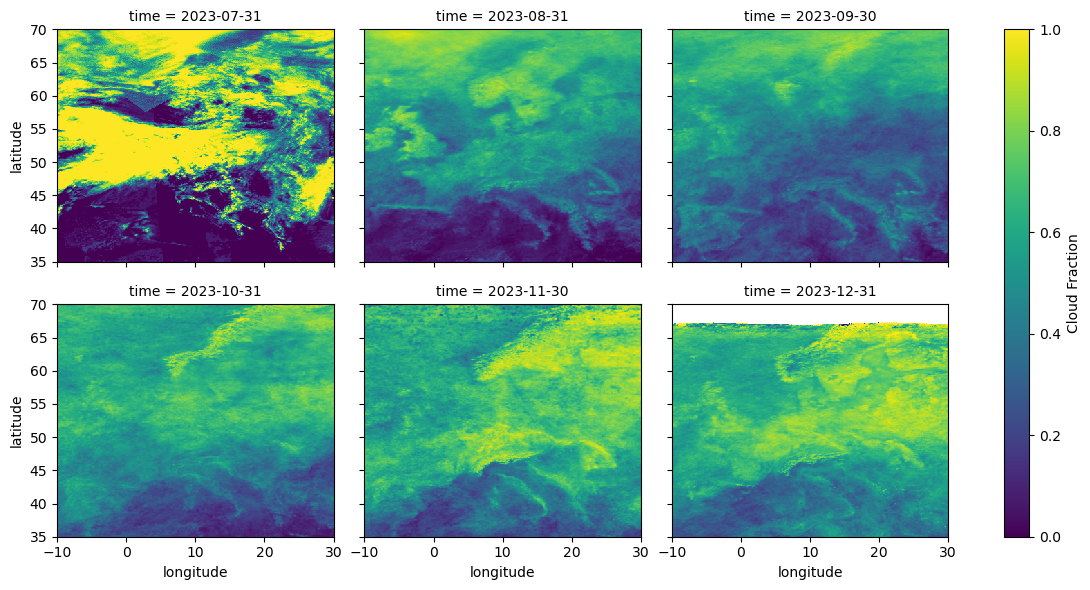

In [90]:
res.plot(col="time",
    col_wrap=3,
    cmap="viridis",
    vmin=0,
    vmax=1,
    figsize=(12, 6),
    cbar_kwargs={"label": "Cloud Fraction"})

In [91]:
# Load and process with openEO
# Save with openEO 
# Check the results
# Check the metadata against best practices
# Register to STAC API

In [ ]:
# metadata?
# register to STAC API?

## NO2

https://radiantearth.github.io/stac-browser/#/external/eoapi.develop.eoepca.org/stac/collections/terrascope-s5p-l3-no2-td-v2?.language=de

In [2]:
# is there are more elegant way to retrieve the token, than using openEO?
import openeo.rest.auth.oidc
issuer = "https://sso.terrascope.be/auth/realms/terrascope" # get this from stac auth extension
client_id = "public"

provider = openeo.rest.auth.oidc.OidcProviderInfo(issuer=issuer)
client_info = openeo.rest.auth.oidc.OidcClientInfo(client_id=client_id, provider=provider)  
authenticator = openeo.rest.auth.oidc.OidcDeviceAuthenticator(client_info=client_info)

In [3]:
tokens = authenticator.get_tokens()

Visit https://sso.terrascope.be/auth/realms/terrascope/device?user_code=EIPZ-NDYY 📋 to authenticate.

✅ Authorized successfully

In [4]:
token = tokens.access_token
token

'eyJhbGciOiJSUzI1NiIsInR5cCIgOiAiSldUIiwia2lkIiA6ICJPLVNHU0xodzdZZy1LOFVZdVlOeTlVNUpYU3Fsdk5nTm1yN1FCOS1LLUEwIn0.eyJleHAiOjE3NjI4ODAxNDAsImlhdCI6MTc2Mjg3OTg0MCwiYXV0aF90aW1lIjoxNzYyODc4MzQxLCJqdGkiOiIyYzQ3MzFlNS04MmZmLTQ5ZjgtYjRlNi1kZGQ5NDIzNjVmMzYiLCJpc3MiOiJodHRwczovL3Nzby50ZXJyYXNjb3BlLmJlL2F1dGgvcmVhbG1zL3RlcnJhc2NvcGUiLCJhdWQiOlsiYnJva2VyIiwiYWNjb3VudCJdLCJzdWIiOiI0YWJkNDk5Mi0yNGU1LTRlMTUtOGM2YS1jMWE3MTlhZGNmMWYiLCJ0eXAiOiJCZWFyZXIiLCJhenAiOiJwdWJsaWMiLCJzZXNzaW9uX3N0YXRlIjoiZTE1MWQyYzAtOGRjMy00ZTJmLTkzMTQtMzE3Y2QzNTBhMmJkIiwicmVhbG1fYWNjZXNzIjp7InJvbGVzIjpbImRlZmF1bHQtcm9sZXMtdGVycmFzY29wZSIsIm9mZmxpbmVfYWNjZXNzIiwidW1hX2F1dGhvcml6YXRpb24iXX0sInJlc291cmNlX2FjY2VzcyI6eyJicm9rZXIiOnsicm9sZXMiOlsicmVhZC10b2tlbiJdfSwiYWNjb3VudCI6eyJyb2xlcyI6WyJtYW5hZ2UtYWNjb3VudCIsIm1hbmFnZS1hY2NvdW50LWxpbmtzIiwidmlldy1wcm9maWxlIl19fSwic2NvcGUiOiJvcGVuaWQgcHJvZmlsZSBlbWFpbCIsInNpZCI6ImUxNTFkMmMwLThkYzMtNGUyZi05MzE0LTMxN2NkMzUwYTJiZCIsImVtYWlsX3ZlcmlmaWVkIjp0cnVlLCJyb2xlIjpbImRlZmF1bHQtcm9sZXMtdGVycmF

In [5]:
import rasterio

In [6]:
url = "https://eoapi.develop.eoepca.org/stac" # eoepca
#url = "https://stac.terrascope.be/" # terrascope

In [7]:
catalog = Client.open(url)

collection_id = "terrascope-s5p-l3-no2-td-v2"
bbox = [-10.0, 35.0, 30.0, 70.0]  # Europe
date_time = "2023-08-01T00:00:00Z/2023-12-31T23:59:59Z"

search = catalog.search(
    collections=[collection_id],
    bbox=bbox,
    datetime=date_time,
    limit=400  
)

items = list(search.items())

# added for auth
with rasterio.Env(
    CPL_VSIL_CURL_ALLOWED_EXTENSIONS="tif",
    GDAL_DISABLE_READDIR_ON_OPEN="YES",
    VSI_CACHE="TRUE",
    GDAL_HTTP_HEADERS=f"Authorization: Bearer {token}"
):
    ds = stac_load(
        items,  
        crs="EPSG:4326",
        resolution=0.1,
        bbox=bbox,
        chunks={"time": 1}, 
        fail_on_error=False, # dangerous
    )


In [8]:
monthly_mean_no2 = ds['NO2'].groupby('time.month').median(dim='time')
monthly_mean_no2

<xarray.DataArray 'NO2' (month: 5, latitude: 350, longitude: 400)> Size: 3MB
dask.array<stack, shape=(5, 350, 400), dtype=float32, chunksize=(1, 350, 400), chunktype=numpy.ndarray>
Coordinates:
  * latitude     (latitude) float64 3kB 69.95 69.85 69.75 ... 35.25 35.15 35.05
  * longitude    (longitude) float64 3kB -9.95 -9.85 -9.75 ... 29.75 29.85 29.95
    spatial_ref  int32 4B 4326
  * month        (month) int64 40B 8 9 10 11 12

it seems that just empty tiffs are returned.

CPU times: user 4.14 s, sys: 486 ms, total: 4.63 s
Wall time: 23.4 s


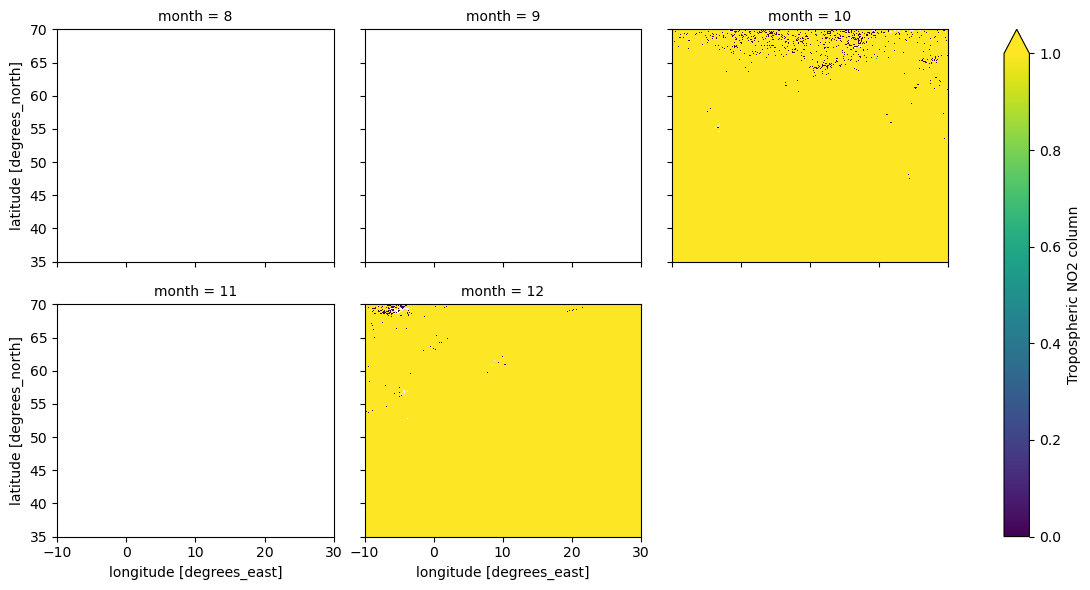

In [10]:
%%time
monthly_mean_no2.plot(col="month",
    col_wrap=3,
    cmap="viridis",
    vmin=0,
    vmax=1,
    figsize=(12, 6),
    cbar_kwargs={"label": "Tropospheric NO2 column"})

In [11]:
monthly_mean_no2.to_series().describe()

count    279775.000000
mean       1943.348389
std        1201.770874
min           0.000000
25%        1126.000000
50%        1814.000000
75%        2489.250000
max       16848.000000
Name: NO2, dtype: float64

In [19]:
monthly_mean = monthly_mean_no2.mean(dim=["latitude", "longitude"], skipna=True)
monthly_min = monthly_mean_no2.min(dim=["latitude", "longitude"])
monthly_max = monthly_mean_no2.max(dim=["latitude", "longitude"])
monthly_std = monthly_mean_no2.std(dim=["latitude", "longitude"])

In [20]:
print(monthly_mean.compute())


<xarray.DataArray 'NO2' (month: 5)> Size: 20B
array([nan, nan, nan, nan, nan], dtype=float32)
Coordinates:
    spatial_ref  int32 4B 4326
  * month        (month) int64 40B 8 9 10 11 12


In [21]:
monthly_mean.to_series().describe()

count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: NO2, dtype: float64

### Some Checks

General checks. No loading. ---> WORKS

In [12]:
print(ds)
print(ds.attrs)
print(ds.coords)
print(ds['NO2'])

<xarray.Dataset> Size: 171MB
Dimensions:      (latitude: 350, longitude: 400, time: 153)
Coordinates:
  * latitude     (latitude) float64 3kB 69.95 69.85 69.75 ... 35.25 35.15 35.05
  * longitude    (longitude) float64 3kB -9.95 -9.85 -9.75 ... 29.75 29.85 29.95
    spatial_ref  int32 4B 4326
  * time         (time) datetime64[ns] 1kB 2023-08-01T00:40:57 ... 2023-12-31...
Data variables:
    NO2          (time, latitude, longitude) float32 86MB dask.array<chunksize=(1, 350, 400), meta=np.ndarray>
    NO2_WEIGHT   (time, latitude, longitude) float32 86MB dask.array<chunksize=(1, 350, 400), meta=np.ndarray>
{}
Coordinates:
  * latitude     (latitude) float64 3kB 69.95 69.85 69.75 ... 35.25 35.15 35.05
  * longitude    (longitude) float64 3kB -9.95 -9.85 -9.75 ... 29.75 29.85 29.95
    spatial_ref  int32 4B 4326
  * time         (time) datetime64[ns] 1kB 2023-08-01T00:40:57 ... 2023-12-31...
<xarray.DataArray 'NO2' (time: 153, latitude: 350, longitude: 400)> Size: 86MB
dask.array<NO2, sha

In [13]:
print(len(items))
for i, it in enumerate(items[:5]):
    print(i, it.assets.keys())

153
0 dict_keys(['NO2', 'preview', 'NO2_WEIGHT'])
1 dict_keys(['NO2', 'preview', 'NO2_WEIGHT'])
2 dict_keys(['NO2', 'preview', 'NO2_WEIGHT'])
3 dict_keys(['NO2', 'preview', 'NO2_WEIGHT'])
4 dict_keys(['NO2', 'preview', 'NO2_WEIGHT'])


Check ONE item ---> FAILS

In [25]:
url = items[1].assets["NO2"].href
print(url)

with rasterio.Env(
    CPL_VSIL_CURL_ALLOWED_EXTENSIONS="tif",
    GDAL_DISABLE_READDIR_ON_OPEN="YES",
    VSI_CACHE="TRUE",
    GDAL_HTTP_HEADERS=f"Authorization: Bearer {token}"
):
    with rasterio.open(url) as src:
        print(src.count, src.crs, src.shape)
        arr = src.read(1)
        print(arr.mean(), arr.min(), arr.max())

https://services.terrascope.be/download/Sentinel5P/L3_NO2_TD_V2/2023/12/S5P_OFFL_L3_NO2_TD_20231230_V200/S5P_NO2_TD_20231230_NO2_V200.tif


RasterioIOError: '/vsicurl/https://services.terrascope.be/download/Sentinel5P/L3_NO2_TD_V2/2023/12/S5P_OFFL_L3_NO2_TD_20231230_V200/S5P_NO2_TD_20231230_NO2_V200.tif' does not exist in the file system, and is not recognized as a supported dataset name.

Check ONE item with rioxarray direct read. --> WORKS

In [26]:
import requests, rioxarray
from io import BytesIO

r = requests.get(url, headers={"Authorization": f"Bearer {token}"})
print(r.status_code, len(r.content))
da = rioxarray.open_rasterio(BytesIO(r.content))
print(da.mean().item(), da.min().item(), da.max().item())


401 381


RasterioIOError: '/vsipythonfilelike/6dbbe739-1a4f-467d-8065-9a5104cafd47/6dbbe739-1a4f-467d-8065-9a5104cafd47' not recognized as a supported file format.

In [14]:
da.to_series().describe()

NameError: name 'da' is not defined

In [20]:
with rasterio.Env(
    GDAL_HTTP_HEADERS=f"Authorization: Bearer {token}",
    GDAL_HTTP_UNSAFESSL="YES",
    GDAL_DISABLE_READDIR_ON_OPEN="YES",
    GDAL_HTTP_MAX_RETRY="3",
    CPL_VSIL_CURL_ALLOWED_EXTENSIONS="tif",
    GDAL_HTTP_COOKIEFILE="/vsimem/cookies.txt"
):
    ds = stac_load(
        items,
        bands=["NO2"],   # explicitly request the correct band
        crs="EPSG:4326",
        resolution=0.1,
        bbox=bbox,
        chunks={"time": 1},
        fail_on_error=False,
    )

In [21]:
monthly_mean_no2 = ds['NO2'].groupby('time.month').median(dim='time')
monthly_mean_no2

<xarray.DataArray 'NO2' (month: 5, latitude: 350, longitude: 400)> Size: 3MB
dask.array<stack, shape=(5, 350, 400), dtype=float32, chunksize=(1, 350, 400), chunktype=numpy.ndarray>
Coordinates:
  * latitude     (latitude) float64 3kB 69.95 69.85 69.75 ... 35.25 35.15 35.05
  * longitude    (longitude) float64 3kB -9.95 -9.85 -9.75 ... 29.75 29.85 29.95
    spatial_ref  int32 4B 4326
  * month        (month) int64 40B 8 9 10 11 12

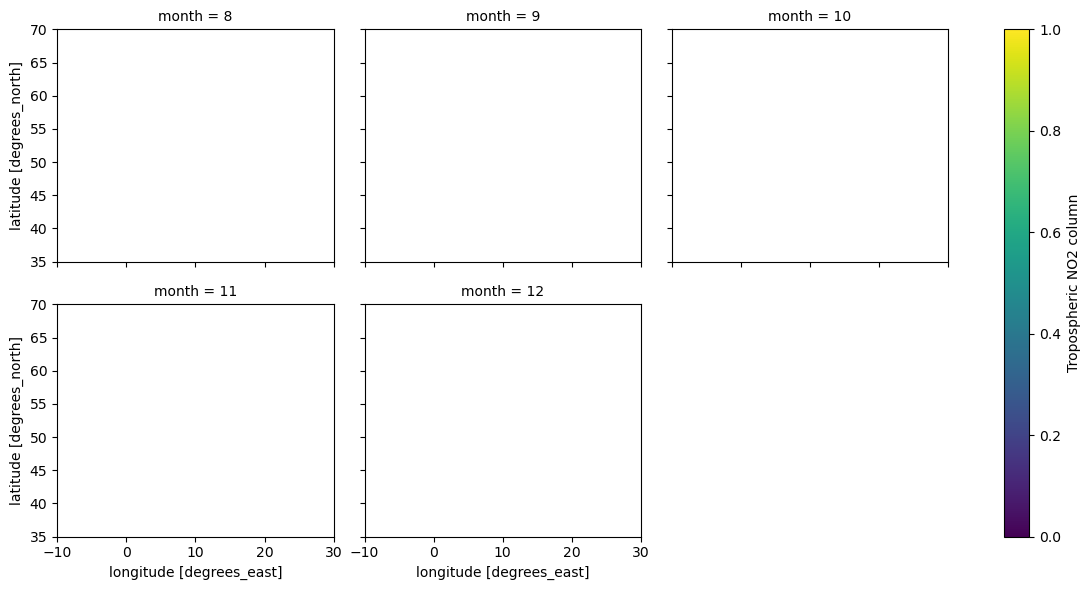

In [19]:
monthly_mean_no2.plot(col="month",
    col_wrap=3,
    cmap="viridis",
    vmin=0,
    vmax=1,
    figsize=(12, 6),
    cbar_kwargs={"label": "Tropospheric NO2 column"})

In [22]:
def http_reader(href, **kwargs):
    headers = {"Authorization": f"Bearer {token}"}
    r = requests.get(href, headers=headers)
    r.raise_for_status()
    return rioxarray.open_rasterio(BytesIO(r.content), **kwargs)

ds = stac_load(
    items,
    reader=http_reader,
    crs="EPSG:4326",
    resolution=0.1,
    bbox=bbox,
)

Aborting load due to failure while reading: https://services.terrascope.be/download/Sentinel5P/L3_NO2_TD_V2/2023/12/S5P_OFFL_L3_NO2_TD_20231231_V200/S5P_NO2_TD_20231231_NO2_V200.tif:1


RasterioIOError: '/vsicurl/https://services.terrascope.be/download/Sentinel5P/L3_NO2_TD_V2/2023/12/S5P_OFFL_L3_NO2_TD_20231231_V200/S5P_NO2_TD_20231231_NO2_V200.tif' does not exist in the file system, and is not recognized as a supported dataset name.